In [1]:
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()
sns.set_color_codes("colorblind")

results_raw = pd.read_parquet("results/performance.parquet")
ecmo_size = torch.load("cache/ihmtensors/X_ecmo.pt").shape[0]

results_raw['Fine Tuning Size'] = results_raw['Fine Tuning Size'].apply(lambda x: ecmo_size if x == 0 else x)

pretty_names_map = {
    'combined': 'All ICUs',
    'micu': 'Medical',
    'sicu': 'Surgical',
    'cvicu': 'Cardiovascular',
    'ccu': 'Coronary Care Unit',
    'tsicu': 'Trauma Surgical',
    'nsicu': 'Neurosurgical',
    'msicu': 'Medical Surgical',
    None: 'Unpretrained'
}

results_raw['Pretraining'] = results_raw['Pretraining'].apply(lambda x: pretty_names_map[x])
results_raw = results_raw.rename(columns={'Pretraining': 'ICU Type'})
results_raw.to_csv("results/performance.csv", index=False)


# Performance vs. Fine-Tuning Size

In [2]:
pvft = results_raw[results_raw['Pretraining Size'] == 0].drop(columns=['Pretraining Size'])
pvft = pvft[(pvft['ICU Type'] == 'All ICUs') | (pvft['ICU Type'] == 'Medical')]

[Text(0.5, 1.0, 'Model Performance vs. Fine-Tuning Dataset Size')]

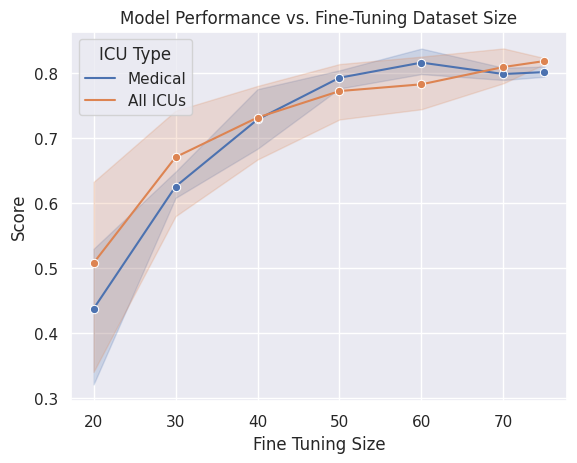

In [3]:
sns.set_theme()

sns.lineplot(
    data=pvft, 
    x="Fine Tuning Size", 
    y="Score", 
    hue="ICU Type", 
    marker='o',
).set(title='Model Performance vs. Fine-Tuning Dataset Size')

# Fixed (n = 1000) vs. Maximum Pretraining Size

In [4]:
fvmp = results_raw[results_raw['Fine Tuning Size'] == ecmo_size].drop(columns=['Fine Tuning Size'])
fixed_pretraining = fvmp[fvmp['Pretraining Size'] == 1000]
max_pretraining = fvmp[fvmp['Pretraining Size'] == 0]

[Text(0.5, 1.0, 'Model Performance by Pretraining Dataset')]

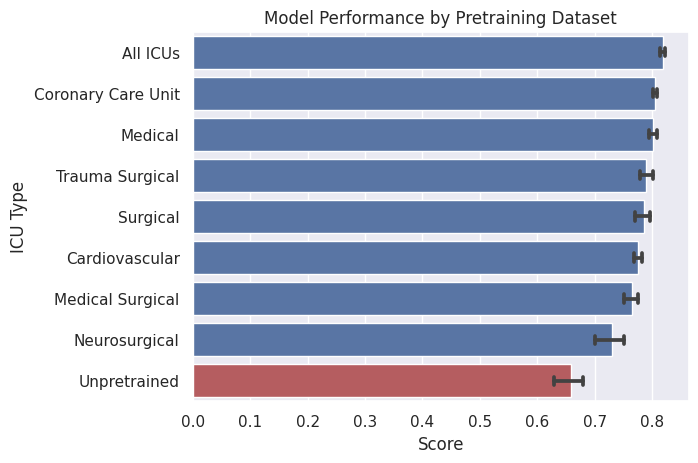

In [5]:
plot_order = max_pretraining.groupby('ICU Type')['Score'].mean().sort_values(ascending=False).index.values
clrs = ['r' if (x == 'Unpretrained') else 'b' for x in plot_order ]

sns.barplot(
    data=max_pretraining, 
    x="Score", 
    y="ICU Type", 
    capsize=0.2,
    order=plot_order,
    orient='h',
    palette=clrs
).set(title='Model Performance by Pretraining Dataset')

[Text(0.5, 1.0, 'Model Performance by Pretraining Dataset\nfixed pretraining dataset size (n=1000)')]

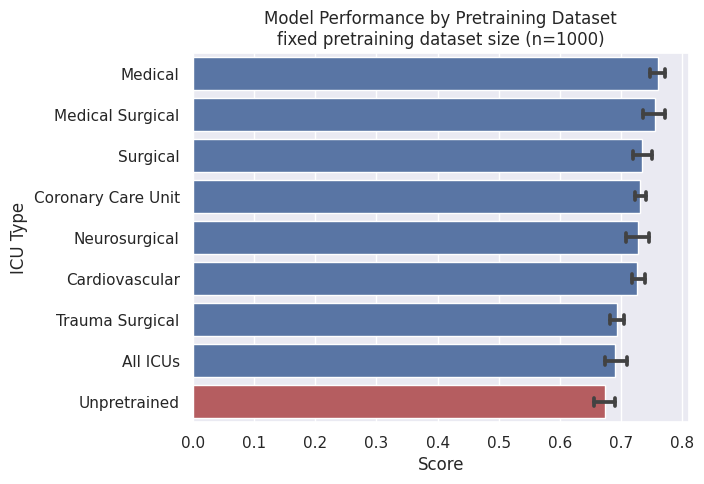

In [6]:
plot_order = fixed_pretraining.groupby('ICU Type')['Score'].mean().sort_values(ascending=False).index.values
clrs = ['r' if (x == 'Unpretrained') else 'b' for x in plot_order ]

sns.barplot(
    data=fixed_pretraining, 
    x="Score", 
    y="ICU Type", 
    capsize=0.2,
    order=plot_order,
    orient='h',
    palette=clrs
).set(title="Model Performance by Pretraining Dataset\nfixed pretraining dataset size (n=1000)")

# Performance by Pretraining Dataset Size

In [7]:
pvpt = results_raw[(results_raw['Pretraining Size'] != 0) & (results_raw['Pretraining Size'] != 1000)]

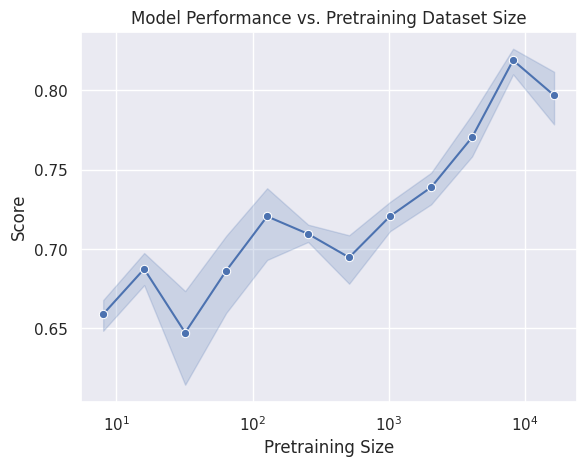

In [8]:
sns.set_theme()

sns.lineplot(
    data=pvpt, 
    x="Pretraining Size", 
    y="Score",
    marker='o',
).set(title='Model Performance vs. Pretraining Dataset Size')
plt.xscale('log')

# Attributions

In [9]:
from tabecmo.dataProcessing import features, feat_category_map

attribs_raw = torch.load('cache/attribs.pt')
attribs_raw = torch.abs(attribs_raw)
attribs_raw = torch.sum(attribs_raw, axis=0)

attribs_df = pd.DataFrame(data={'Feature': features, 'Attribution': attribs_raw})

attribs_df.to_csv("results/attributions.csv", index=False)
attribs_df['Category'] = attribs_df['Feature'].apply(lambda x: feat_category_map[x])

attribs_df

,Feature,Attribution,Category
0,AbsoluteBasophilCount,0.813283,CBC
1,AbsoluteEosinophilCount,0.279888,CBC
2,AbsoluteLymphocyteCount,1.095906,CBC
3,AbsoluteMonocyteCount,0.573100,CBC
4,AbsoluteNeutrophilCount,0.516472,CBC
...,...,...,...
78,temperature,0.228964,Vitals
79,thrombin,0.335929,Coagulation
80,total_protein,0.207179,LFTs
81,totalco2,1.096329,Blood Gases


[Text(0.5, 1.0, 'Summed Absolute Attributions')]

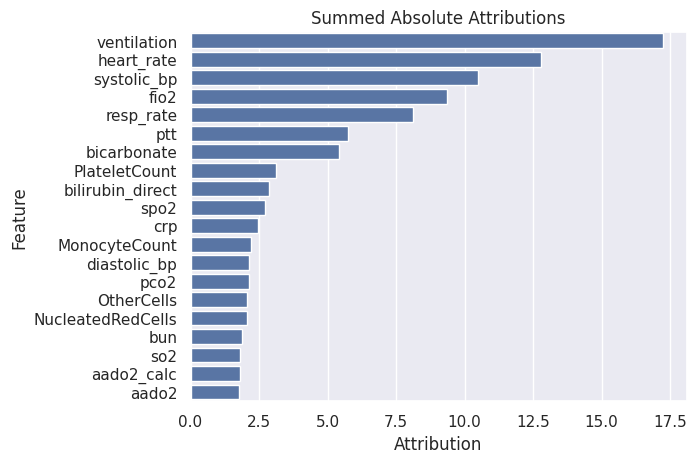

In [10]:

sns.barplot(
    data=attribs_df.nlargest(20, columns=['Attribution']),
    x="Attribution", 
    y="Feature", 
    orient='h',
    palette=['b'] * len(features)
).set(title='Summed Absolute Attributions')

In [ ]:
# Unpretrained attribs

In [17]:

experiment_groups = results_raw[results_raw['Fine Tuning Size'] == 75].groupby(['ICU Type', 'Pretraining Size'])

aggregated_statistics = experiment_groups['Score'].agg(['mean', 'median', 'std', 'sem', 'count'])
aggregated_statistics.to_csv("results/aggregated_stats.csv")
aggregated_statistics

mean    median       std       sem  \
ICU Type           Pretraining Size                                           
All ICUs           0                 0.818314  0.819041  0.006124  0.002739   
                   8                 0.659012  0.663517  0.012241  0.005474   
                   16                0.687500  0.691134  0.013252  0.005926   
                   32                0.647384  0.650436  0.039551  0.017688   
                   64                0.686337  0.686047  0.028826  0.012891   
                   128               0.720640  0.728924  0.028448  0.012722   
                   256               0.709593  0.708576  0.006810  0.003045   
                   512               0.694767  0.699128  0.019776  0.008844   
                   1000              0.689971  0.683140  0.023299  0.010420   
                   1024              0.720785  0.722384  0.011968  0.005352   
                   2048              0.738953  0.745640  0.012810  0.005729   
                   4096              0.770494  0.762355  0.016319  0.007298   
                   8192              0.819041  0.823401  0.011081  0.004956   
                   16384             0.796948  0.803052  0.021519  0.009624   
Cardiovascular     0                 0.776163  0.780523  0.008841  0.003954   
                   1000              0.726163  0.723837  0.013136  0.005875   
Coronary Care Unit 0                 0.804797  0.805233  0.004498  0.002011   
                   1000              0.731250  0.728198  0.011368  0.005084   
Medical            0                 0.801308  0.799419  0.010065  0.004501   
                   1000              0.759593  0.768895  0.016456  0.007359   
Medical Surgical   0                 0.764535  0.766715  0.015044  0.006728   
                   1000              0.755233  0.759448  0.021847  0.009770   
Neurosurgical      0                 0.730523  0.740552  0.034213  0.015300   
                   1000              0.727180  0.726744  0.024696  0.011045   
Surgical           0                 0.785610  0.792878  0.018015  0.008057   
                   1000              0.734302  0.726017  0.020013  0.008950   
Trauma Surgical    0                 0.789680  0.787064  0.015558  0.006958   
                   1000              0.692878  0.683140  0.014703  0.006575   
Unpretrained       0                 0.658140  0.667878  0.034471  0.015416   
                   1000              0.672674  0.685320  0.022509  0.010066   

                                     count  
ICU Type           Pretraining Size         
All ICUs           0                     5  
                   8                     5  
                   16                    5  
                   32                    5  
                   64                    5  
                   128                   5  
                   256                   5  
                   512                   5  
                   1000                  5  
                   1024                  5  
                   2048                  5  
                   4096                  5  
                   8192                  5  
                   16384                 5  
Cardiovascular     0                     5  
                   1000                  5  
Coronary Care Unit 0                     5  
                   1000                  5  
Medical            0                     5  
                   1000                  5  
Medical Surgical   0                     5  
                   1000                  5  
Neurosurgical      0                     5  
                   1000                  5  
Surgical           0                     5  
                   1000                  5  
Trauma Surgical    0                     5  
                   1000                  5  
Unpretrained       0                     5  
                   1000                  5